# Optimization of an X-Gate for a Transmon Qubit

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
%watermark -v --iversions

qutip       4.3.1
numpy       1.15.4
scipy       1.1.0
matplotlib  3.0.1
matplotlib.pylab  1.15.4
krotov      0.0.1
CPython 3.6.7
IPython 7.1.1


In [2]:
import sys

## Define the Hamiltonian

In [3]:
def transmon_ham_and_states(Ec=0.386, EjEc=45, nstates=8, ng=0.0, T=10.0, steps=1000):
    """Transmon Hamiltonian"""
    Ej = EjEc * Ec
    n = np.arange(-nstates, nstates+1)
    up = np.diag(np.ones(2*nstates),k=-1)
    do = up.T
    H0 = qutip.Qobj(np.diag(4*Ec*(n - ng)**2) - Ej*(up+do)/2.0)
    H1 = qutip.Qobj(-2*np.diag(n))
    
    eigenvals, eigenvecs = scipy.linalg.eig(H0.full())
    ndx = np.argsort(eigenvals.real)
    E = eigenvals[ndx].real
    V = eigenvecs[:,ndx]
    w01 = E[1]-E[0] # Transition energy between states
    
    psi0 = qutip.Qobj(V[:, 0])
    psi1 = qutip.Qobj(V[:, 1])    
    
    profile = lambda t: np.exp(-40.0*(t/T - 0.5)**2)
    eps0 = lambda t, args: 0.5 * profile(t) * np.cos(8*np.pi*w01*t)
    return ([H0, [H1, eps0]], psi0, psi1)

In [4]:
H, psi0, psi1 = transmon_ham_and_states()

In [5]:
proj0 = psi0 * psi0.dag()
proj1 = psi1 * psi1.dag()

In [6]:
tlist=np.linspace(0, 10, 1000)

## Simulate dynamics of the guess pulse

In [7]:
guess_dynamics = qutip.mesolve(H, psi0, e_ops=[proj0, proj1], tlist=tlist)

In [8]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

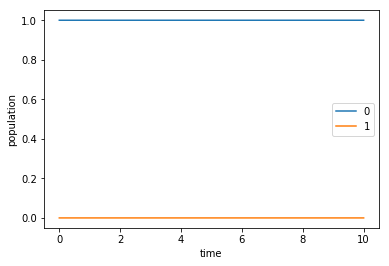

In [9]:
plot_population(guess_dynamics)

## Optimize

In [10]:
objectives = [
    krotov.Objective(initial_state=psi0, target_state=psi1, H=H),
    krotov.Objective(initial_state=psi1, target_state=psi0, H=H)
]

In [11]:
#{H[1][1]: 2}

In [12]:
#krotov.krotov(objectives, [])